
# Diagnose von Diabetes mellitus mithilfe maschinellen Lernens

Hier finden Sie den gesamten Code, den der Autor für die Analyse verwendet hat.

Auch einzusehen unter: https://github.com/NicoPiel/LiteraturSeminar

In [96]:
# Setup

import numpy as np

# Ein Zufalls-Seed für Reproduzierbarkeit
np.random.seed(42)

from datetime import datetime
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report, matthews_corrcoef
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils
from tensorflow.keras.regularizers import l1, l2, l1_l2

from IPython.display import display, clear_output

sns.set_theme()

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
print(f"GPUs für die Berechnung: {len(tf.config.experimental.list_physical_devices('GPU'))}")

%matplotlib inline
%matplotlib widget

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
GPUs für die Berechnung: 0


In [97]:
# Daten importieren
data = pd.read_csv('data/diabetes.csv')

# Nullen durch NaN ersetzen
data["Glucose"] = data["Glucose"].replace(0, np.nan)
data["BloodPressure"] = data["BloodPressure"].replace(0, np.nan)
data["SkinThickness"] = data["SkinThickness"].replace(0, np.nan)
data["Insulin"] = data["Insulin"].replace(0, np.nan)
data["BMI"] = data["BMI"].replace(0, np.nan)
data["DiabetesPedigreeFunction"] = data["DiabetesPedigreeFunction"].replace(0, np.nan)
data["Age"] = data["Age"].replace(0, np.nan)

# NaN Werte imputieren
imputer = KNNImputer(n_neighbors=3)

data_imputed = pd.DataFrame(imputer.fit_transform(data))
data_imputed.columns = data.columns

# Vorbereitung

Als Erstes möchten wir uns ein wenig Übersicht verschaffen, also Data Exploration betreiben.

In [98]:
# Spalten

data_imputed.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [99]:
# Übersicht verschaffen

data_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,126.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,106.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,33.0,325.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [100]:
data_imputed.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000
mean,3.742775,121.865968,72.386802,29.394870,154.245303,32.571038,0.471193,33.132225,0.343931
std,3.323801,30.691555,12.405154,10.878381,113.830777,7.143838,0.325669,11.777230,0.475104
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.000000,27.500000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,30.000000,125.000000,32.300000,0.375000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.725000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,846.000000,80.600000,2.420000,81.000000,1.000000


Die einzelnen Spalten haben folgende Bedeutung:

- **Pregnancies:** Anzahl der bisherigen (erfolgreichen und gescheiterten) Schwangerschaften
- **Glucose:** 75g-2-h-oGTT in $\frac{\text{mg}}{\text{dl}}$. Glukosewert nach 75g Kohlenhydraten und zwei Stunden Wartezeit
- **BloodPressure:** Diastolischer Blutdruck in $\text{mm} \cdot \text{Hg}$
- **SkinThickness:** Dicke der Trizepshautfalte in $\text{mm}$
- **Insulin:** Seruminsulin nach 2 Stunden in $\frac{\text{µU}}{\text{ml}}$
- **BMI:** Body-Mass-Index in $\frac{\text{kg}}{\text{m}^2}$
- **DiabetesPedigreeFunction:** Stammbaumfunktion des Patienten
- **Age:** Alter in Jahren
- **Outcome:** Klassifikation. 1 = Diabetes, 0 = kein Diabetes

In [101]:
# Keine sichtbare Beziehung zwischen

#sns.pairplot(data = data_imputed, hue="Outcome")
#plt.savefig('pairplot.png', dpi=300)

In [102]:
# Pearson-Koeffizienten für alle Spalten

for col in data_imputed:
    for col2 in data_imputed:
        if col != col2:
            arr1 = data_imputed[col].to_numpy()
            arr2 = data_imputed[col2].to_numpy()
        
            pearson = stats.pearsonr(arr1, arr2)
            
            if (pearson[0] > 0.3) or (pearson[0] < -0.3):
                print(f"{col} -> {col2}: r = {np.round(pearson[0], 2)}, p = {np.round(pearson[1], 2)}")

Pregnancies -> Age: r = 0.54, p = 0.0
Glucose -> Insulin: r = 0.51, p = 0.0
Glucose -> Outcome: r = 0.49, p = 0.0
BloodPressure -> Age: r = 0.33, p = 0.0
SkinThickness -> BMI: r = 0.54, p = 0.0
Insulin -> Glucose: r = 0.51, p = 0.0
BMI -> SkinThickness: r = 0.54, p = 0.0
Age -> Pregnancies: r = 0.54, p = 0.0
Age -> BloodPressure: r = 0.33, p = 0.0
Outcome -> Glucose: r = 0.49, p = 0.0


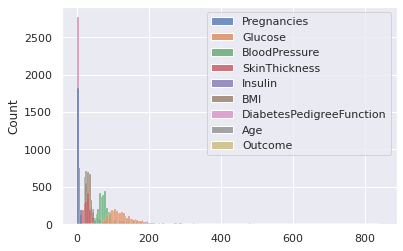

In [20]:
plot = sns.histplot(data=data)
plt.show(plot)

Aus den Pearson-Koeffizienten lässt sich schließen, dass die klinischen Werte nur wenig direkten Einfluss aufeinander haben.

Die Anzahl der Schwangerschaften scheint mit dem Alter, die Dicke der Trizeps-Hautfalte mit dem BMI zu korrelieren.
Überraschenderweise scheint der 75g-2h-oGGT nur mittelmäßig mit dem Ergebnis zusammenzuhängen.

# Das Modell

In [103]:
def nn(random_state):
    # Input-Daten
    X = data_imputed[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].values
    # Der Wert, der vorhergesagt werden soll
    y = data_imputed['Outcome'].values

    # Train-Test-Split als 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    
    #Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Das Modell soll aufhören zu rechnen, falls es keine nennenswerten Verbesserungen mehr gibt
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001,
        patience=64,
        restore_best_weights=True
    )
    
    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))

    # Das NN besteht aus einer Mischung von Dense-, Normalization- und Dropout-Layern.
    network = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid', name='output'),
    ])

    # NN kompilieren
    network.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[keras.metrics.BinaryAccuracy()]
    )

    history = network.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=512,
        epochs=512,
        shuffle=True,
        callbacks=[early_stopping],
        verbose=0
    )

    # Scores berechnen
    # history_df = pd.DataFrame(history.history)

    y_pred = network.predict(X_test)
    y_pred_corrected = []

    for pred in y_pred:
        if pred >= 0.5:
            y_pred_corrected.append(1)
        else: 
            y_pred_corrected.append(0)

    f1 = f1_score(y_test, y_pred_corrected, average='macro')
    mcc = matthews_corrcoef(y_test, y_pred_corrected)
    report = sklearn.metrics.classification_report(y_test, y_pred_corrected)
    # confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_corrected)
    # print(confusion_matrix)
    # print(report)
    return f1, mcc, report, network

    # history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
    # history_df.loc[5:, ['loss', 'val_loss']].plot()

In [104]:
# 100 verschiedene Modelle trainieren und in einen DataFrame speichern
# Das kann ein paar Stunden dauern

results = {}

for i in np.arange(5):
    f1, mcc, report, model = nn(i)
    results[i] = [model, f1, mcc, report]
    clear_output()
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['model', 'f1', 'mcc', 'report'])
    display(df_results)

model        f1       mcc  \
0  <tensorflow.python.keras.engine.sequential.Seq...  0.962491  0.925657   
1  <tensorflow.python.keras.engine.sequential.Seq...  0.946090  0.892209   
2  <tensorflow.python.keras.engine.sequential.Seq...  0.929847  0.866167   
3  <tensorflow.python.keras.engine.sequential.Seq...  0.947711  0.895452   
4  <tensorflow.python.keras.engine.sequential.Seq...  0.915762  0.833047   

                                               report  
0                 precision    recall  f1-score   ...  
1                 precision    recall  f1-score   ...  
2                 precision    recall  f1-score   ...  
3                 precision    recall  f1-score   ...  
4                 precision    recall  f1-score   ...  
5                 precision    recall  f1-score   ...  
6                 precision    recall  f1-score   ...  
7                 precision    recall  f1-score   ...  
8                 precision    recall  f1-score   ...  
9                 precision    recall  f1-score   ...  
10                precision    recall  f1-score   ...  
11                precision    recall  f1-score   ...  
12                precision    recall  f1-score   ...  
13                precision    recall  f1-score   ...  
14                precision    recall  f1-score   ...  
15                precision    recall  f1-score   ...  
16                precision    recall  f1-score   ...  
17                precision    recall  f1-score   ...  
18                precision    recall  f1-score   ...  
19                precision    recall  f1-score   ...  
20                precision    recall  f1-score   ...  
21                precision    recall  f1-score   ...  
22                precision    recall  f1-score   ...  
23                precision    recall  f1-score   ...  
24                precision    recall  f1-score   ...  
25                precision    recall  f1-score   ...  
26                precision    recall  f1-score   ...  
27                precision    recall  f1-score   ...  
28                precision    recall  f1-score   ...  
29                precision    recall  f1-score   ...  
30                precision    recall  f1-score   ...  
31                precision    recall  f1-score   ...  
32                precision    recall  f1-score   ...  
33                precision    recall  f1-score   ...  
34                precision    recall  f1-score   ...  
35                precision    recall  f1-score   ...  
36                precision    recall  f1-score   ...  
37                precision    recall  f1-score   ...  
38                precision    recall  f1-score   ...  
39                precision    recall  f1-score   ...  
40                precision    recall  f1-score   ...  
41                precision    recall  f1-score   ...  
42                precision    recall  f1-score   ...  
43                precision    recall  f1-score   ...  
44                precision    recall  f1-score   ...  
45                precision    recall  f1-score   ...  
46                precision    recall  f1-score   ...  
47                precision    recall  f1-score   ...  
48                precision    recall  f1-score   ...  
49                precision    recall  f1-score   ...

In [105]:
# DataFrame nach bestem F1-Score sortieren
df_results_sorted = df_results.sort_values(by=['f1', 'mcc'], ascending=False)

# Die besten 10 Modelle speichern
for i in np.arange(5):
    df_results_sorted.iloc[i].model.save(f'models/model{i}.h5')

In [106]:
df_results.describe()

,f1,mcc
count,5.000000,5.000000
mean,0.940380,0.882507
std,0.017974,0.034774
min,0.915762,0.833047
25%,0.929847,0.866167
50%,0.946090,0.892209
75%,0.947711,0.895452
max,0.962491,0.925657
